In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import pickle
import xgboost as xgb
import eli5
from collections import defaultdict

In [63]:
sns.set(style="white")
sns.set_context("paper")

#matplotlib.use('pgf')

def figsize(scale,ratio, fig_width_pt=252):
    # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

In [59]:

from xgboost.sklearn import XGBModel
from xgboost.core import Booster

def custom_plot_importance(booster, nice_names, ax=None, height=0.2,
						   xlim=None, ylim=None, title='Feature importance',
						   xlabel='F score', ylabel='Features',
						   importance_type='weight',
						   grid=True, **kwargs):
	"""Plot importance based on fitted trees.
	Parameters
	----------
	booster : Booster, XGBModel or dict
		Booster or XGBModel instance, or dict taken by Booster.get_fscore()
	ax : matplotlib Axes, default None
		Target axes instance. If None, new figure and axes will be created.
	importance_type : str, default "weight"
		How the importance is calculated: either "weight", "gain", or "cover"
		"weight" is the number of times a feature appears in a tree
		"gain" is the average gain of splits which use the feature
		"cover" is the average coverage of splits which use the feature
			where coverage is defined as the number of samples affected by the split
	height : float, default 0.2
		Bar height, passed to ax.barh()
	xlim : tuple, default None
		Tuple passed to axes.xlim()
	ylim : tuple, default None
		Tuple passed to axes.ylim()
	title : str, default "Feature importance"
		Axes title. To disable, pass None.
	xlabel : str, default "F score"
		X axis title label. To disable, pass None.
	ylabel : str, default "Features"
		Y axis title label. To disable, pass None.
	kwargs :
		Other keywords passed to ax.barh()
	Returns
	-------
	ax : matplotlib Axes
	"""
	# TODO: move this to compat.py
	try:
		import matplotlib.pyplot as plt
	except ImportError:
		raise ImportError('You must install matplotlib to plot importance')

	if isinstance(booster, XGBModel):
		importance = booster.booster().get_score(importance_type=importance_type)
	elif isinstance(booster, Booster):
		importance = booster.get_score(importance_type=importance_type)
	elif isinstance(booster, dict):
		importance = booster
	else:
		raise ValueError('tree must be Booster, XGBModel or dict instance')

	if len(importance) == 0:
		raise ValueError('Booster.get_score() results in empty')

	tuples = [(k, importance[k]) for k in importance]
	tuples = sorted(tuples, key=lambda x: x[1])
	labels, values = zip(*tuples)

	extra_neigh = ['prox_metro', 'prox_railway',
				   'dist_airport', 'prox_parks', 'dist_industrial_area', 'n_bus_stops',
				   'prox_coffee', 'prox_enter', 'prox_shops', 'prox_restaurants', 'prox_school', 'prox_grocery',
				   'prox_library']
	extra_neigh.extend(['employees', 'population',
						'prox_metro', 'prox_railway', 'assessed_land_value',
						'dist_airport', 'prox_parks', 'dist_industrial_area', 'n_bus_stops',
						'prox_coffee', 'prox_enter', 'prox_shops', 'prox_restaurants', 'prox_school', 'prox_grocery',
						'prox_library',
						'vacant_buildings', '#_comm_buildings', 'score'])
	extra_neigh = set(extra_neigh)

	neigh_indexes = [i for i, k in enumerate(tuples) if 'neigh_' in k[0] or k[0] in extra_neigh]
	noneigh_indexes = [i for i, k in enumerate(tuples) if 'neigh_' not in k[0] and k[0] not in extra_neigh]

	if ax is None:
		_, ax = plt.subplots(1, 1)

	ylocs = np.arange(len(values))
	values = np.array(values)
	labels = np.array(labels)

	ax.barh(ylocs[noneigh_indexes], values[noneigh_indexes], align='center', height=height, **kwargs)
	ax.barh(ylocs[neigh_indexes], values[neigh_indexes], align='center', height=height, **kwargs)

	for x, y in zip(values, ylocs):
		ax.text(x + 1, y, x, va='center')

	ax.set_yticks(ylocs)
	ax.set_yticklabels([nice_names[x] if x in nice_names else x for x in labels])

	if xlim is not None:
		if not isinstance(xlim, tuple) or len(xlim) != 2:
			raise ValueError('xlim must be a tuple of 2 elements')
	else:
		xlim = (0, max(values) * 1.1)
	ax.set_xlim(xlim)

	if ylim is not None:
		if not isinstance(ylim, tuple) or len(ylim) != 2:
			raise ValueError('ylim must be a tuple of 2 elements')
	else:
		ylim = (-1, len(importance))
	ax.set_ylim(ylim)

	if title is not None:
		ax.set_title(title)
	if xlabel is not None:
		ax.set_xlabel(xlabel)
	if ylabel is not None:
		ax.set_ylabel(ylabel)
	ax.grid(grid)
    
	return ax

In [52]:
nice_names = {
				'employees': 'employees',
				'population': 'population',
				'prox_metro': 'proximity metro',
				'prox_railway': 'proximity railway st.',
				'assessed_land_value': 'property taxes',
				'dist_airport': 'proximity airport',
				'prox_parks': 'proximity parks',
				'dist_industrial_area': 'proximity industrial area',
				'n_bus_stops': '# bus stops neighborhood',
				'prox_coffee': 'proximity coffee places',
				'prox_enter': 'proximity entertainment',
				'prox_shops': 'proximity shops',
				'prox_restaurants': 'proximity restaurants',
				'prox_school': 'proximity schools',
				'prox_grocery': 'proximity groceres',
				'prox_library': 'proximity library',
				'vacant_buildings': 'vacant buildings',
				'#_comm_buildings': 'commercial buildings',

				'#_buildings': 'buildings',
				'#_res_buildings': 'residential buildings',
				'neigh_urban_sum': 'm2_urban neigh', 'neigh_comm_sum': 'm2_commercial neigh', 'neigh_other_sum': 'm2_other neigh',
				'neigh_green_sum': 'm2_green neigh',

				# 'census_area',

				'neigh_E8': 'buildings age', 'neigh_E9': 'buildings age', 'neigh_E10': 'buildings age',
				'neigh_E11': 'buildings age', 'neigh_E12': 'buildings age', 'neigh_E13': 'buildings age',
				'neigh_E14': 'buildings age', 'neigh_E15': 'buildings age', 'neigh_E16': 'buildings age',
				'neigh_fatturato': 'net euro from companies neigh',
				'neigh_num_companies': '# companies neigh',

				'neigh_employees': '# people working neigh',
				'neigh_population': '# residents [neigh]',
				'neigh_m2_residential': 'Residential sqmt',

				'neigh_score': 'security perception [neigh]',
'neigh_heavy_ind': 'heavy industries [neigh]',
'neigh_creative_ind': 'creative industries [neigh]',
				'sqmt': 'square meters',
				'constructionYear': 'building age',
				'energyClass': 'energyClass',
				'expensesCondominium': 'expenses condominium',
				'Piscina': 'has_pool',
				'Videocitofono': 'has_intercom',
				'Idromassaggio': 'has_jacuzzi',
				'Mansarda': 'has_attic',
				'Campo da tennis': 'has_tennis',
				'Cantina': 'has_cellar',
				'Impianto allarme': 'has_alarm', 'Taverna': 'has_tavern',
				'Cancello elettrico': 'has_eletric_gate', 'Porta blindata': 'has_armored_door', 'Camino': 'has_fireplace',
				'Fibra ottica': 'has_fiber',
				'infissi': 'fixtures_type', 'portiere': 'has_doorman', 'giardino': 'has_garden', 'arredato': 'is_furnished',
				'esposizione': 'sun_exposition_type',
				'newFloorNumber': 'floor number',
				'placeType_Appartamento': 'is_apartment',
				'placeType_Attico / Mansarda': 'is_attic',
				'placeType_Casa indipendente': 'is_indipedent_house',
				'placeType_Loft / Open Space': 'is_loft',
				'placeType_Villa': 'is_villa',
				'placeType_Villetta a schiera': 'is_villetta',
				'locali': '# rooms', 'camere': '# bedrooms', 'bagni': '# bathrooms', 'altro': '# other rooms',
				'kitchen': 'Kitchen type',
				'condition': 'condition',
'land_value': 'property taxes'
		}

toadd = {}
for k, v in nice_names.items():
    toadd['neigh_'+k] = v+' [neigh]'
    
for k, v in toadd.items():
    nice_names[k] = v

In [18]:
bst = pickle.load(open('data/generated_files/trained_price.model', "rb"))
importance = bst.get_score(importance_type='weight')

## Full importance plot

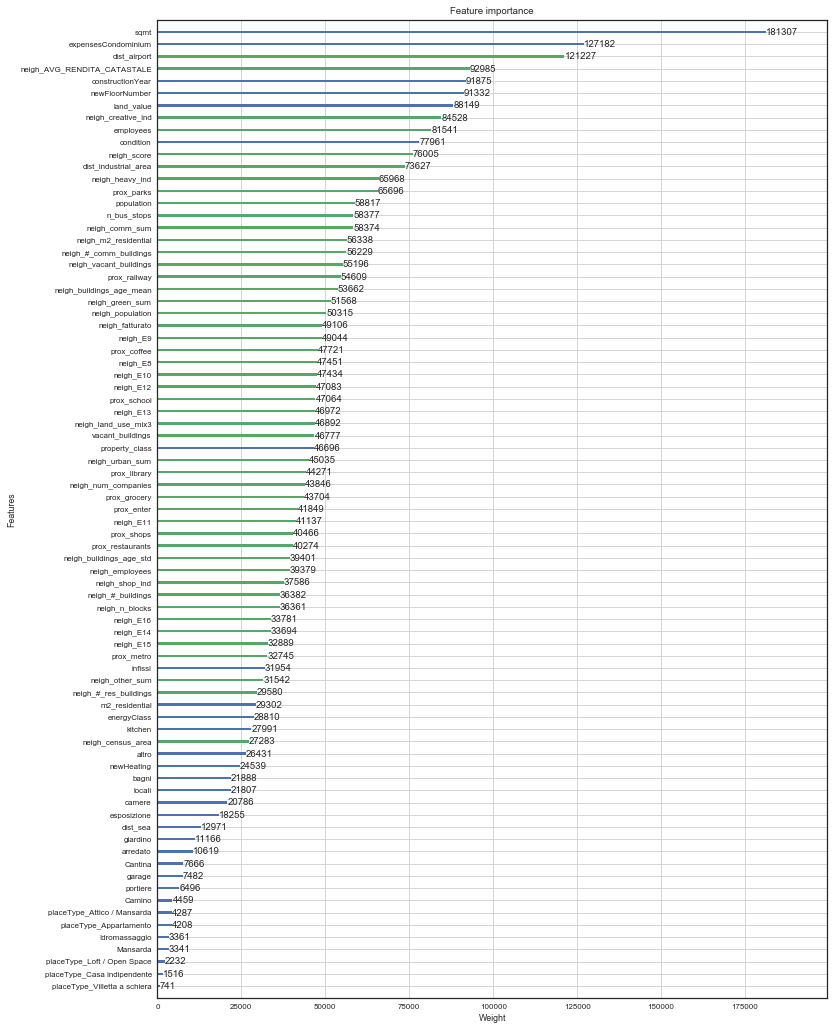

In [5]:
fig, ax = plt.subplots(figsize=(12, 18))
custom_plot_importance(bst, {}, xlabel='Weight', ax=ax)

## Top-N importance plot

In [56]:
def autolabel(bars):
    # attach some text labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width*0.95, bar.get_y() + bar.get_height()/2,
                '%d' % int(width), fontsize=6,
                ha='right', va='center', color='white')
        
def plot_top_N_importance(booster, nice_names, N=15, ax=None, height=0.2,
						   xlim=None, ylim=None, title='Feature importance',
						   xlabel='F score', ylabel='Features',
						   importance_type='weight', property_color=None, neigh_color=None,
						   grid=True, **kwargs):
	try:
		import matplotlib.pyplot as plt
	except ImportError:
		raise ImportError('You must install matplotlib to plot importance')

	if isinstance(booster, XGBModel):
		importance = booster.booster().get_score(importance_type=importance_type)
	elif isinstance(booster, Booster):
		importance = booster.get_score(importance_type=importance_type)
	elif isinstance(booster, dict):
		importance = booster
	else:
		raise ValueError('tree must be Booster, XGBModel or dict instance')

	if len(importance) == 0:
		raise ValueError('Booster.get_score() results in empty')

	tuples = [(k, importance[k]) for k in importance]
	tuples = sorted(tuples, key=lambda x: x[1])[-N:]
	labels, values = zip(*tuples)

	extra_neigh = ['prox_metro', 'prox_railway',
				   'dist_airport', 'prox_parks', 'dist_industrial_area', 'n_bus_stops',
				   'prox_coffee', 'prox_enter', 'prox_shops', 'prox_restaurants', 'prox_school', 'prox_grocery',
				   'prox_library']
	extra_neigh.extend(['employees', 'population',
						'prox_metro', 'prox_railway', 'assessed_land_value',
						'dist_airport', 'prox_parks', 'dist_industrial_area', 'n_bus_stops',
						'prox_coffee', 'prox_enter', 'prox_shops', 'prox_restaurants', 'prox_school', 'prox_grocery',
						'prox_library',
						'vacant_buildings', '#_comm_buildings', 'score'])
	extra_neigh = set(extra_neigh)

	neigh_indexes = [i for i, k in enumerate(tuples) if 'neigh_' in k[0] or k[0] in extra_neigh]
	noneigh_indexes = [i for i, k in enumerate(tuples) if 'neigh_' not in k[0] and k[0] not in extra_neigh]

	if ax is None:
		_, ax = plt.subplots(1, 1)

	ylocs = np.arange(len(values))
	values = np.array(values)
	labels = np.array(labels)

	a = ax.barh(ylocs[noneigh_indexes], values[noneigh_indexes], align='center', height=height, color=property_color, **kwargs)
	b = ax.barh(ylocs[neigh_indexes], values[neigh_indexes], align='center', height=height, color=neigh_color, **kwargs)
	autolabel(a)
	autolabel(b)

	ax.set_yticks(ylocs)
	ax.set_yticklabels([nice_names[x] if x in nice_names else x for x in labels])
	ax.set_xticks([])

	if ylim is not None:
		if not isinstance(ylim, tuple) or len(ylim) != 2:
			raise ValueError('ylim must be a tuple of 2 elements')
	else:
		ylim = (-1, N)
	ax.set_ylim(ylim)
	ax.set_title("Top {} Features' importance".format(N))
	ax.set_xlim(0, np.max(values)+10)
	return ax

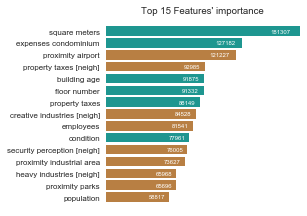

In [57]:
property_color = np.array([30, 150, 144, 255])/255
neigh_color = np.array([184, 127, 67, 255])/255

fig, ax = plt.subplots(figsize=figsize(1, 1))
plot_top_N_importance(bst, nice_names, xlabel='Weight', ax=ax, height=0.8, property_color=property_color, neigh_color=neigh_color)
sns.despine(left=True, bottom=True)
plt.savefig('figures/top_importance.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

## Alluvial diagram

In [72]:
alluvial_groups = {
    'Perception': ['neigh_score'],
    'Textual features': ['sqmt',
       'constructionYear', 'energyClass', 'expensesCondominium',

           'newFloorNumber', 'newHeating', 'portiere', 'infissi', 'giardino', 'arredato', 'esposizione', 'kitchen',
           'condition', 'land_value',

       #'Piscina',
       'Idromassaggio',
       'Mansarda',
       #'Campo da tennis',
       'Cantina', #'Impianto allarme',
       #'Cancello elettrico', 'Porta blindata',
                  'Camino',
       #'Fibra ottica',
       'has_terrace', 'garage',

           'placeType_Appartamento', 'placeType_Attico / Mansarda',
       'placeType_Casa indipendente', 'placeType_Loft / Open Space',
       'placeType_Villetta a schiera', #'placeType_Villa',
                  'property_class', 'property_type',
           'locali', 'camere', 'altro', 'bagni',],
    'Urban fabric': ['neigh_#_buildings',
         'neigh_#_res_buildings',
         'neigh_#_comm_buildings',
         'neigh_urban_sum', 'neigh_comm_sum', 'neigh_other_sum', 'neigh_green_sum',

         'neigh_census_area',

         'neigh_E8', 'neigh_E9', 'neigh_E10', 'neigh_E11', 'neigh_E12', 'neigh_E13', 'neigh_E14', 'neigh_E15', 'neigh_E16',
         'neigh_num_companies',

         'neigh_employees',
         'neigh_population',
         'neigh_vacant_buildings',
         'neigh_m2_residential','neigh_assessed_land_value','neigh_land_use_mix3',

         'neigh_buildings_age_mean', 'neigh_buildings_age_std',
         'neigh_n_blocks', 'neigh_fatturato',
                    
                    
         'dist_airport',
         
         #'d_closest_park0',
         
         'dist_industrial_area',
         'dist_sea',
         
                     
                    ],
    'Walkability': [
        'prox_coffee', 'prox_enter', 'prox_shops', 'prox_restaurants', 'prox_school', 'prox_grocery', 'prox_library','prox_parks',
        'n_bus_stops','prox_metro',
         'prox_railway',
    ],
    'Culture & comp.': ['neigh_heavy_ind',
         'neigh_shop_ind',
         'neigh_creative_ind']
}
alluvial_super_groups = {
    'Perception': 'Neighborhood',
    'Culture & comp.': 'Neighborhood',
    'Textual features': 'Property',
    'Urban fabric': 'Neighborhood',
    'Walkability': 'Neighborhood',
}

reversed_alluvial_groups = {v2:k for k,v in alluvial_groups.items() for v2 in v}

tuples = [(k, importance[k]) for k in importance]
importance_dict = defaultdict(int)

for k, imp in tuples:
    if k in reversed_alluvial_groups:
        importance_dict[reversed_alluvial_groups[k]] += imp

print("Type1, Type2, Importance")
for k,v in importance_dict.items():
    print(', '.join([k, alluvial_super_groups[k], str(v)]))

Type1, Type2, Importance
Textual features, Property, 994537
Urban fabric, Neighborhood, 1486784
Walkability, Neighborhood, 516776
Culture & comp., Neighborhood, 188082
Perception, Neighborhood, 76005


## Explain prediction

In [ ]:
df_test = pd.read_csv('data/generated_files/test_df_ubicomp_price.csv', index_col='sez2011')
df_test.head()

In [34]:
df_test['absdiff'] = np.abs(df_test['difference'])
df_test = df_test.sort_values('absdiff').drop('absdiff', axis=1)
df_test.head()

,Unnamed: 0,sqmt,constructionYear,energyClass,expensesCondominium,newFloorNumber,newHeating,portiere,infissi,giardino,...,placeType_Villetta a schiera,property_class,property_type,locali,camere,altro,bagni,prediction,difference,price
sez2011,,,,,,,,,,,,,,,,,,,,,
100250000229,1433,85.0,NaN,11.0,NaN,6.0,2.0,2.0,3.0,1.0,...,0.0,1.0,1.0,3.0,2.0,1.0,1.0,130000.414062,-0.414062,130000.0
580914130188,9402,50.0,1978.0,10.0,NaN,4.0,2.0,0.0,NaN,0.0,...,0.0,1.0,1.0,2.0,1.0,1.0,1.0,109006.734375,-6.734375,109000.0
480170062049,5541,70.0,1300.0,11.0,80.0,4.0,2.0,0.0,3.0,0.0,...,0.0,2.0,1.0,3.0,2.0,1.0,1.0,219990.859375,9.140625,220000.0
12720002316,875,80.0,1965.0,8.0,83.0,6.0,NaN,0.0,6.0,2.0,...,0.0,1.0,1.0,3.0,2.0,1.0,2.0,159013.203125,-13.203125,159000.0
580914160003,9579,52.0,1970.0,11.0,1.0,6.0,NaN,0.0,NaN,0.0,...,0.0,2.0,1.0,2.0,1.0,1.0,1.0,118982.101562,17.898438,119000.0


In [ ]:
cs = df_test.columns[1:-3].tolist()
row = df_test.loc[(df_test.index == 12720002316) & (df_test.price == 159000) & (df_test.expensesCondominium == 83.0), cs]
row

In [ ]:
explain_df = eli5.explain_prediction_df(bst, feature_names=cs, doc=row, is_regression=True, top=(10, 10))
explain_df = explain_df[['feature', 'weight', 'value']]
explain_df = explain_df[explain_df.feature != '<BIAS>']
explain_df

In [45]:
explain_df = explain_df[explain_df.feature != '<BIAS>']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/ma/core.py:2144: RuntimeWarning: invalid value encountered in greater_equal
  condition = (xf >= v1) & (xf <= v2)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/ma/core.py:2144: RuntimeWarning: invalid value encountered in less_equal
  condition = (xf >= v1) & (xf <= v2)


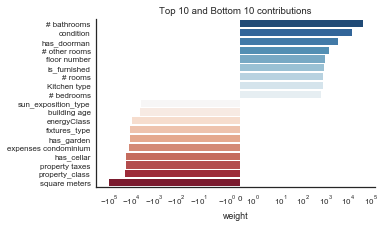

In [66]:
# Center the data to make it diverging
y = [nice_names[x] if x in nice_names else x for x in explain_df['feature']]
x = explain_df['weight']

fig, ax = plt.subplots(figsize=figsize(0.7, "golden", 516))
sns.barplot(x, y, palette="RdBu_r", orient='h', ax=ax)
plt.xscale('symlog')
plt.title("Top 10 and Bottom 10 contributions")
sns.despine()
plt.savefig('figures/explain_prediction.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)